## Problem Statement

<div class="alert alert-warning">
    <strong>We intend to predict whether any given individual is likely to have diabetes using the dataset we obtained from Kaggle which contains 768 data of diabetics and non-diabetic individuals.<br><br>
        Factors include:<br>
        1) Pregnancies<br>
        2) Glucose<br>
        3) Blood Pressure <br>
        4) Skin Thickness <br>
        5) Insulin <br>
        6) BMI <br>
        7) Diabetes Pedigree Function [indicates the function which scores likelihood of diabetes based on family history]<br>
        8) Age <br>
        9) Diabetic Outcome<br>
    </strong>

</div>

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from sklearn.utils import resample,shuffle
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv("diabetes.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


---
## Improving Data By Further Cleaning

In [3]:
#Check for NULL data
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
#Correlation between Variables
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


<div class="alert alert-warning">
    <strong>The dataset contains data filled with integer "0" which signifies NULL. We decided to replace "0"s with NaN.</strong>

</div>



In [5]:
#Replace "0" data with NULL and find the number of NULL for each variable
data[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] = data[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]].replace(0, np.NaN)
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

<div class="alert alert-warning">
    <strong>We decided to drop Insulin and SkinThickness from dataset as there are too many missing data for the variables. We realised there is not much correlation with the diabetes outcome. <br><br>Although blood pressure correlation is low, it have very little missing data. Thus, by replacing it with median might improve the correlation.</strong>

</div>

In [6]:
#Drop Insulin and SkinThickness as explained above.
data = data.drop(["Insulin", "SkinThickness"], axis =1)

In [7]:
#Get the median values
data.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
#Replace zero values in Glucose, BMI, Bloodpressure with median values
data["Glucose"] = data["Glucose"].replace(np.NaN, 117)
data["BMI"] = data["BMI"].replace(np.NaN, 32.3)
data["BloodPressure"] = data["BloodPressure"].replace(np.NaN, 72)
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<div class="alert alert-warning">
    <strong>We replaced the NaN value with median because the outliers will affect the mean.<br>
We don't use mode because it is not a frequency (discrete value) but a continous data.</strong>

</div>




---
## Exploratory Analysis & Data Visualisation

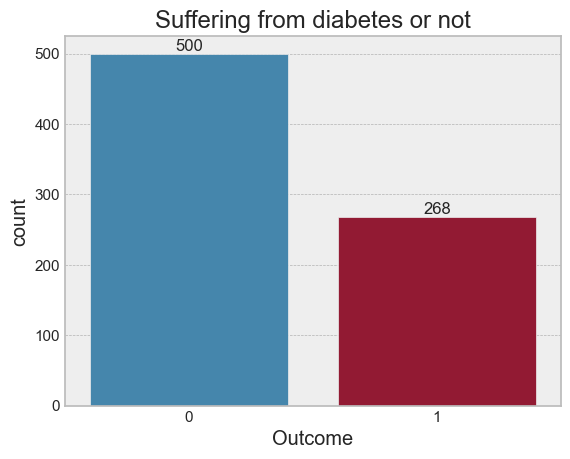

In [9]:
#Count of number of persons suffering diabetes
plt.style.use('bmh')
ax = sb.countplot(x= data.Outcome , data= data)
ax.bar_label(ax.containers[0])
ax.set_title('Suffering from diabetes or not')
plt.show()

<div class="alert alert-warning">
    <strong>We used the appropriate plots to visualize the data for each variable.</strong>

</div>


<AxesSubplot:title={'center':'Counter Plot'}, xlabel='Age', ylabel='count'>

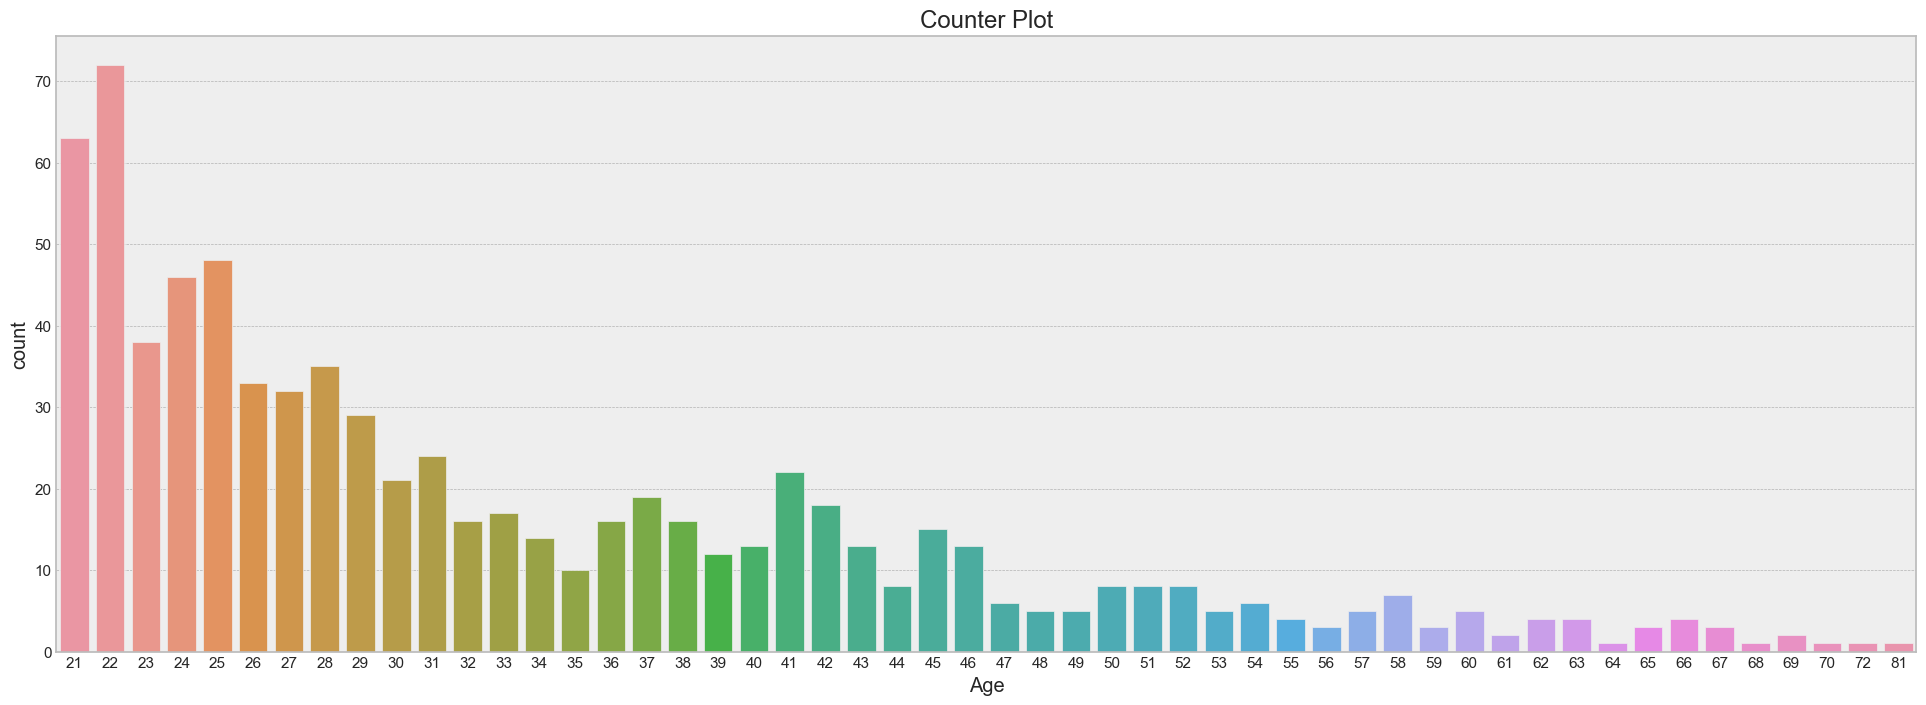

In [10]:
#Age
plt.figure(figsize=(24,8))

plt.title("Counter Plot")
sb.countplot(x = 'Age',data = data)

#plt.subplot(1,3,3)
#plt.title('Outcome Box Plot')
#sb.catplot(data = data, x="Age", y="Outcome", kind="box", orient = "h")

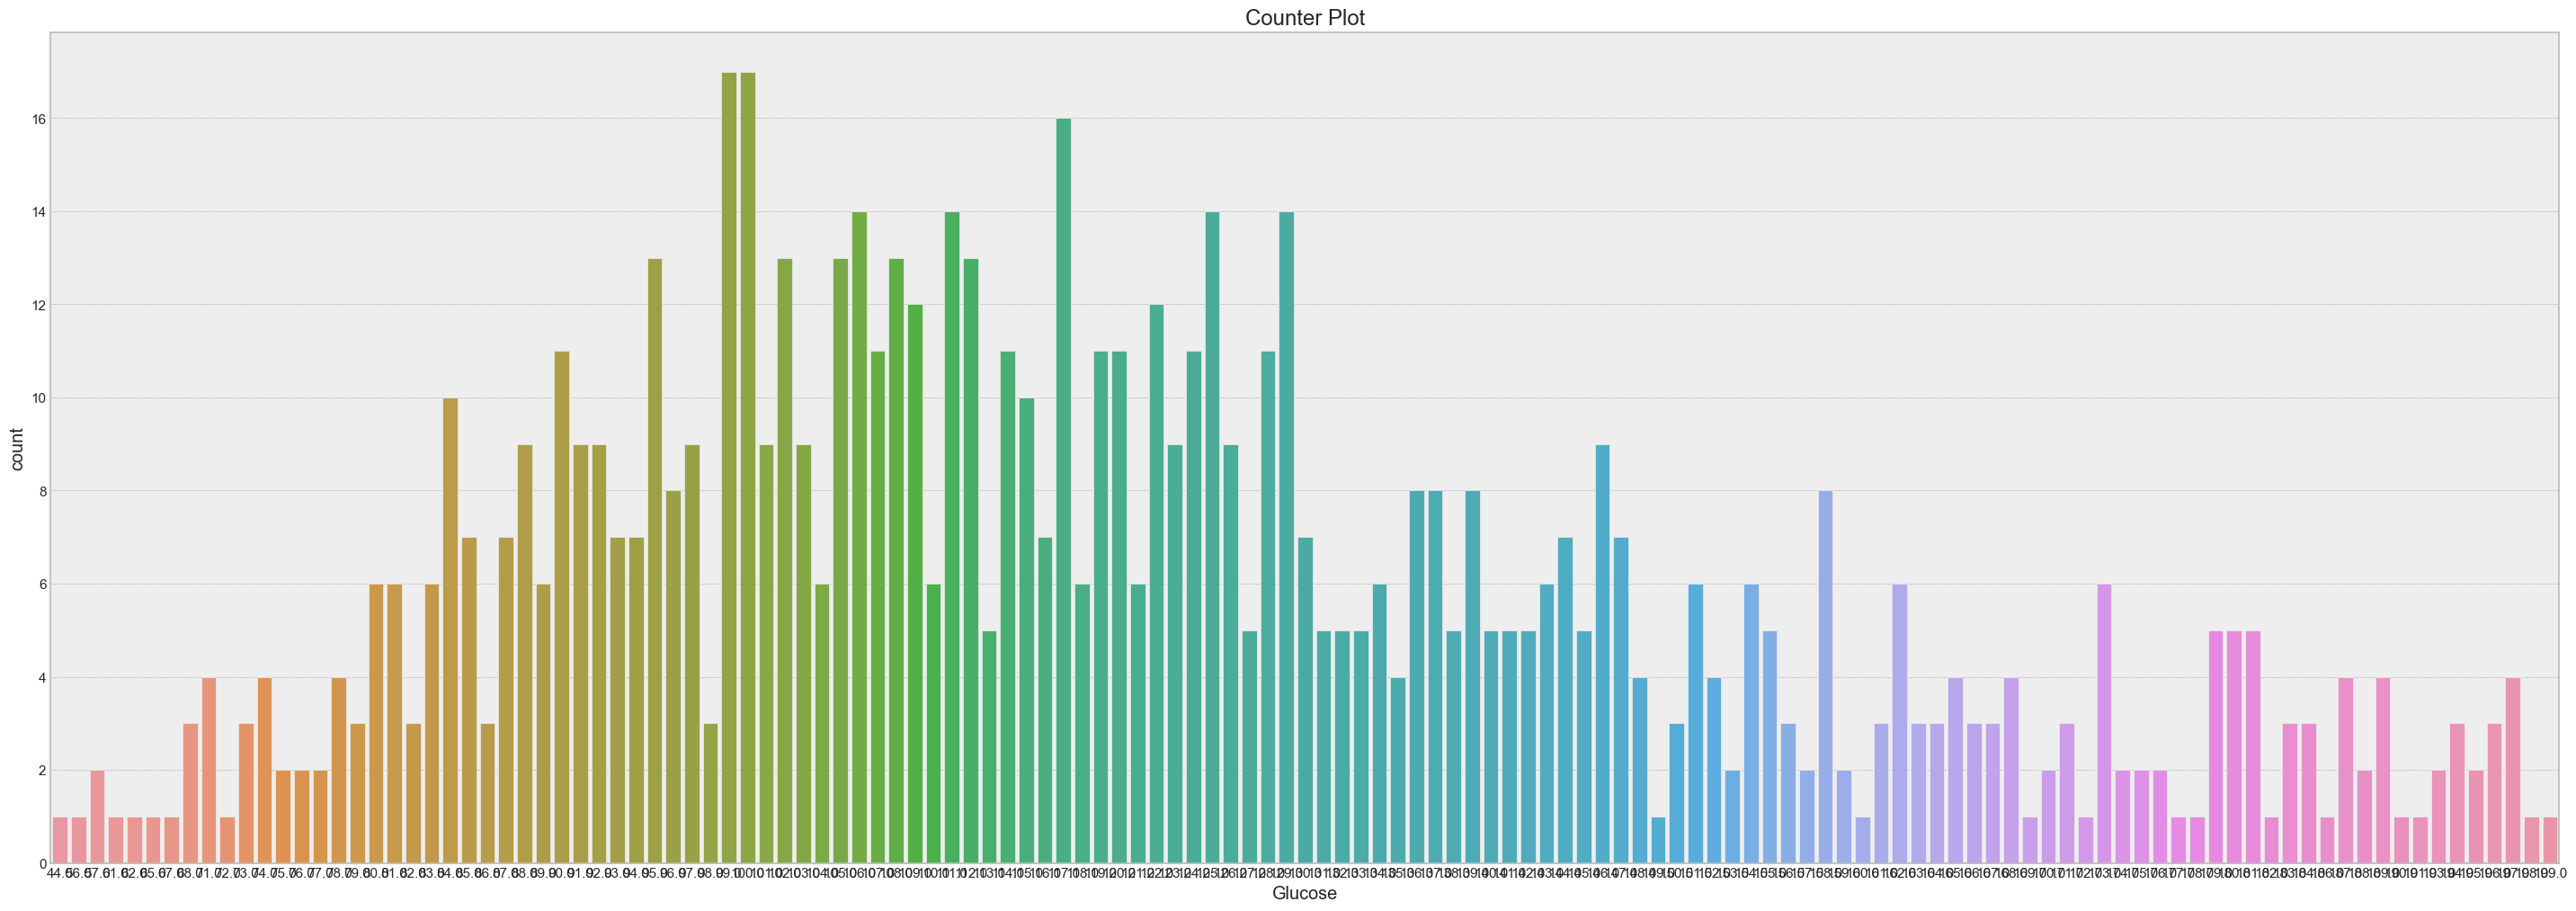

In [11]:
#Glucose
plt.figure(figsize=(36,12))

plt.title("Counter Plot")
sb.countplot(x = 'Glucose',data = data)

plt.show()

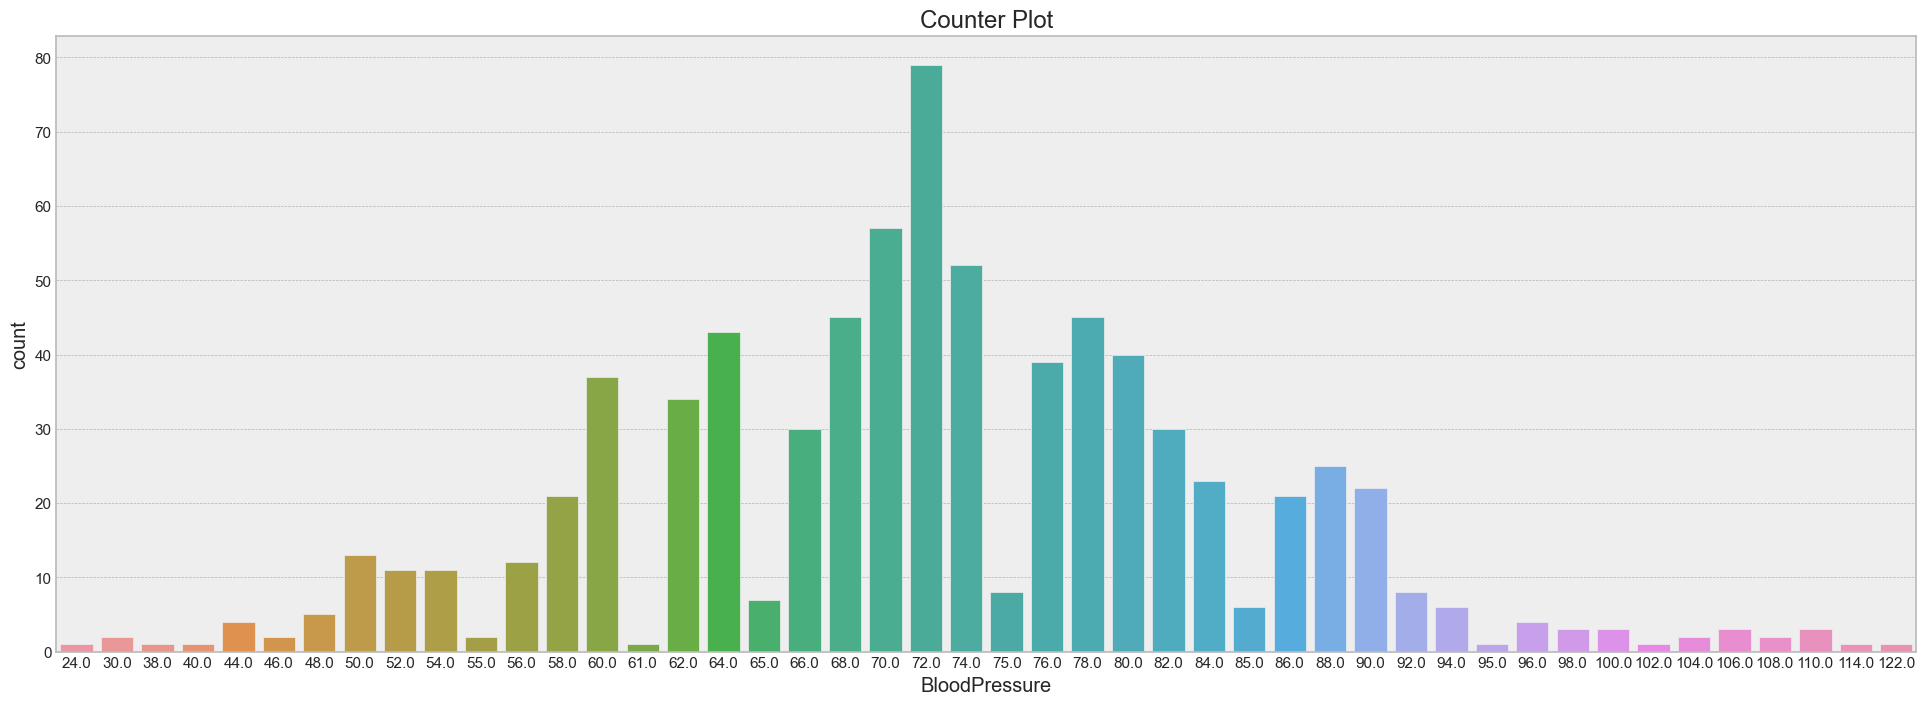

In [12]:
#Blood Pressure
plt.figure(figsize=(24,8))

plt.title("Counter Plot")
sb.countplot(x = 'BloodPressure',data = data)

plt.show()

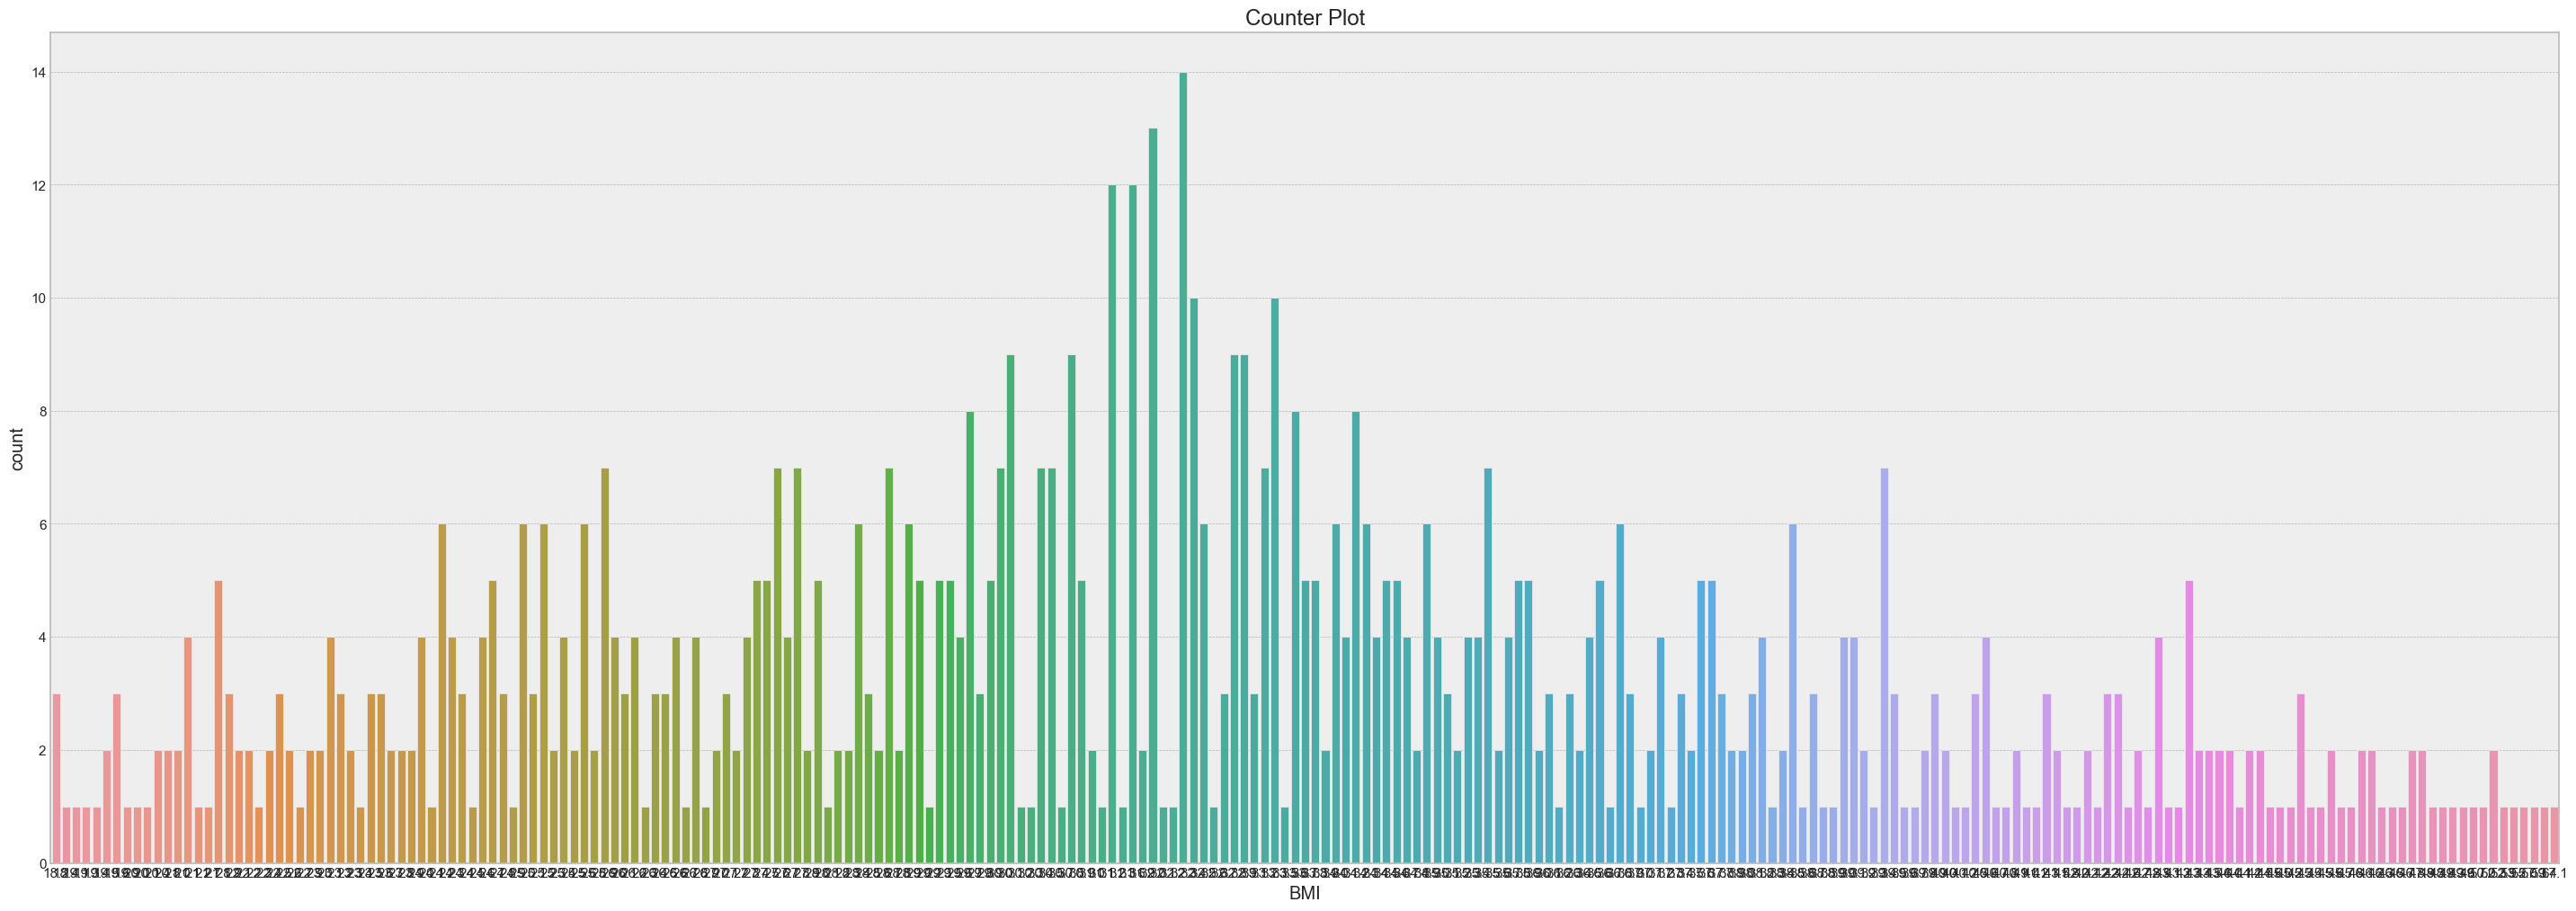

In [13]:
#BMI
plt.figure(figsize=(36,12))

plt.title("Counter Plot")
sb.countplot(x = 'BMI',data = data)

plt.show()

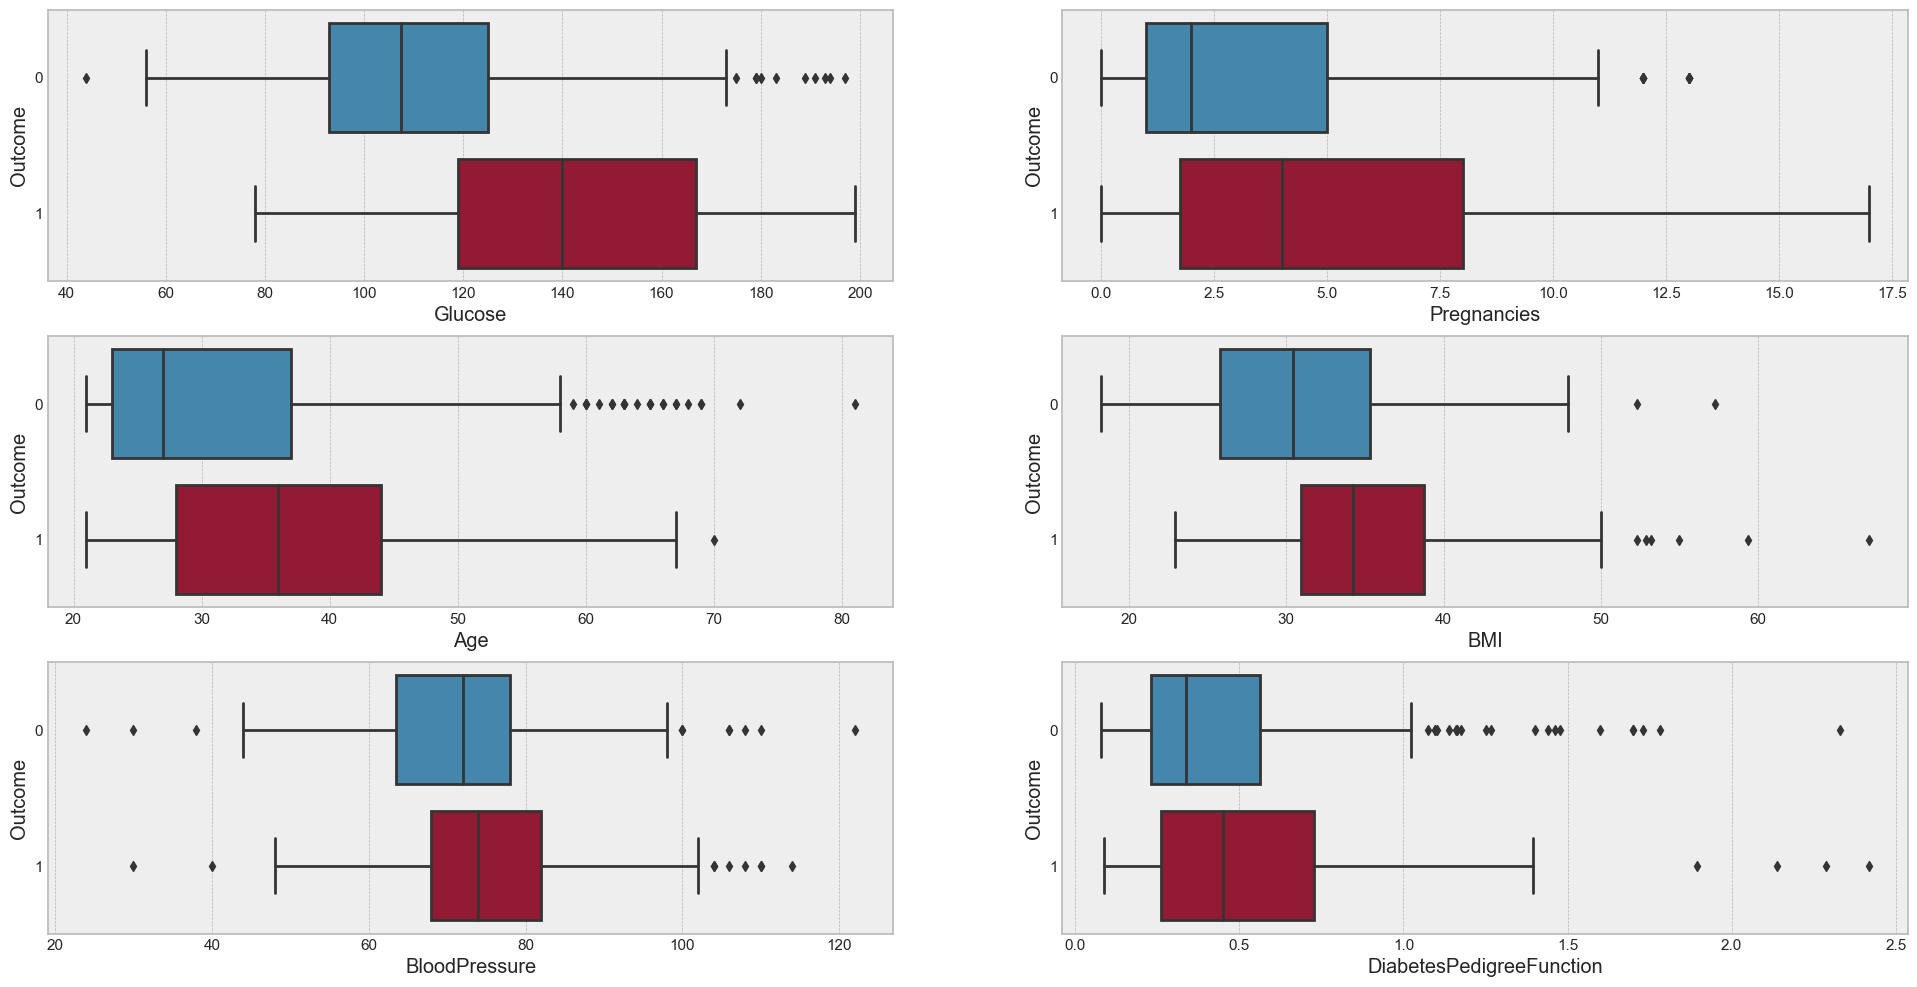

In [14]:
#Categorial Boxplot for Outcome
f, axes = plt.subplots(3, 2, figsize=(24, 12))
sb.boxplot(data= data, x="Glucose", y="Outcome", orient="h", ax = axes[0,0])
sb.boxplot(data= data, x="BMI", y="Outcome", orient="h", ax = axes[1,1])
sb.boxplot(data= data, x="BloodPressure", y="Outcome", orient="h", ax = axes[2,0])
sb.boxplot(data= data, x="Pregnancies", y="Outcome", orient="h", ax = axes[0,1])
sb.boxplot(data= data, x="Age", y="Outcome", orient="h", ax = axes[1,0])
sb.boxplot(data= data, x="DiabetesPedigreeFunction", y="Outcome", orient="h", ax = axes[2,1])
plt.show()

<AxesSubplot:>

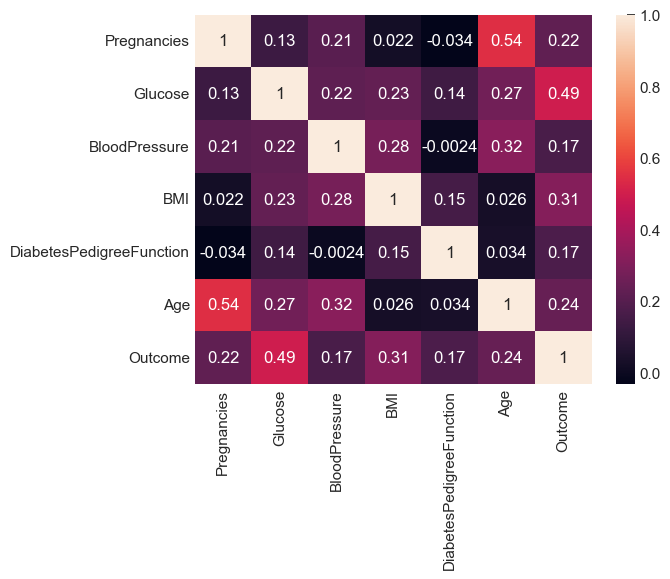

In [15]:
#Correlation Matrix
corr = data.corr()
sb.heatmap(corr,annot=True)

In [16]:
#Function that can be used to calculate linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
linearRegression = LinearRegression()


def calculateLinearRegression(jointFrame,XcolumnName,YcolumnName):
    
    #we test about 20% of the data randomly. Other 80% is used for training.
    testPercentage = math.floor(len(jointFrame) * (20/100))

    TestFrame = jointFrame.sample(testPercentage)
    TrainFrame = jointFrame.loc[~jointFrame.index.isin(TestFrame.index)]

    # Calculate the correlation between the two columns/variables of 2 randomly sampled Data.
    sb.heatmap(jointFrame.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

    
    xAxisTrain = TrainFrame[XcolumnName]
    xAxisTrain = pd.DataFrame(xAxisTrain)

    yAxisTrain = TrainFrame[YcolumnName]
    yAxisTrain = pd.DataFrame(yAxisTrain)

    xAxisTest = TestFrame[XcolumnName]
    xAxisTest = pd.DataFrame(xAxisTest)

    yAxisTest = TestFrame[YcolumnName]
    yAxisTest = pd.DataFrame(yAxisTest)

    # #do linearregression for the Train Data. And calculate the intercept.
    linearRegression.fit(xAxisTrain, yAxisTrain)
    interceptTrain  = linearRegression.intercept_
    coefficientTrain = linearRegression.coef_

    # #formula :coefficient(a) * salePrice + intercept(b)

    x_axis = xAxisTrain #for regression line
    y_axis = coefficientTrain * xAxisTrain + interceptTrain

    #A plot that shows the correlation bewtween Sale Price and Basement Area
    f, axes = plt.subplots(1, 1, figsize=(12, 6))
    plt.scatter(xAxisTrain, yAxisTrain)
    plt.plot(x_axis, y_axis, 'r-', linewidth = 1)
    plt.show()

    # #Goodness of Fit Model:

    yAxisPredict = linearRegression.predict(xAxisTrain)
    yAxisPredict = pd.DataFrame(yAxisPredict)

    #Plot of the Train set using prediction
    f, axes = plt.subplots(1, 1, figsize=(16, 8))
    plt.scatter(xAxisTrain, yAxisTrain)
    plt.scatter(xAxisTrain, yAxisPredict, color = "r")
    plt.show()

    yAxisPredict = linearRegression.predict(xAxisTest)
    yAxisPredict = pd.DataFrame(yAxisPredict)
    #this method takes in the y-axis values of predict vs train.
    print("Mean Squared Error: " ,mean_squared_error(yAxisTest, yAxisPredict))


    #Plot of the Test set using prediction
    f, axes = plt.subplots(1, 1, figsize=(16, 8))
    plt.scatter(xAxisTest, yAxisTest)
    plt.scatter(xAxisTest, yAxisPredict, color = "r")
    plt.show()
    print("Score : ",linearRegression.score(xAxisTest,yAxisTest))

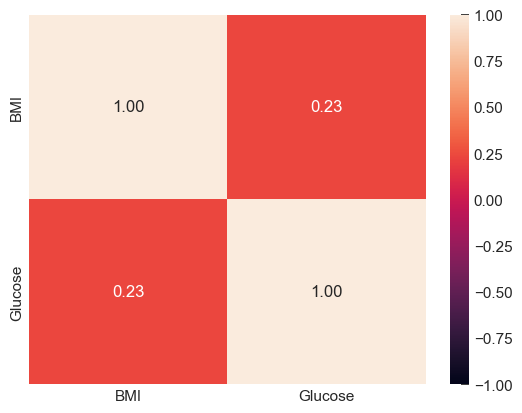

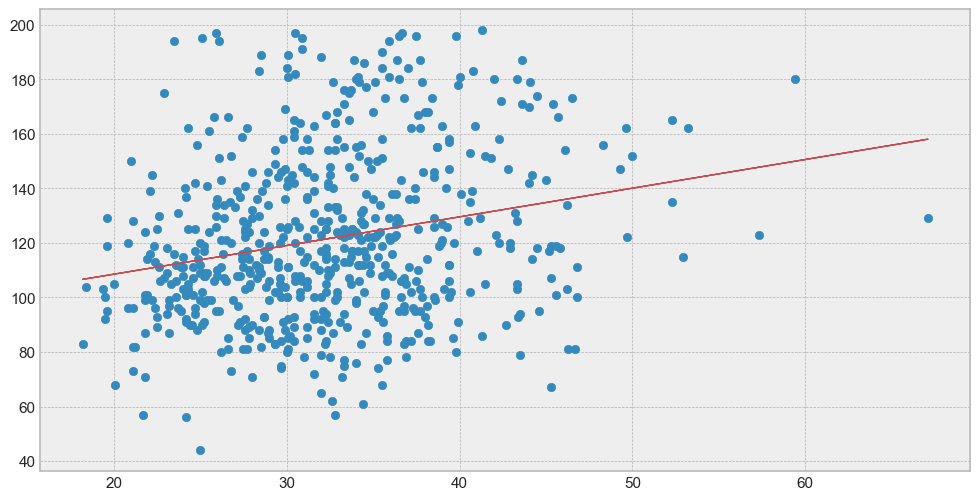

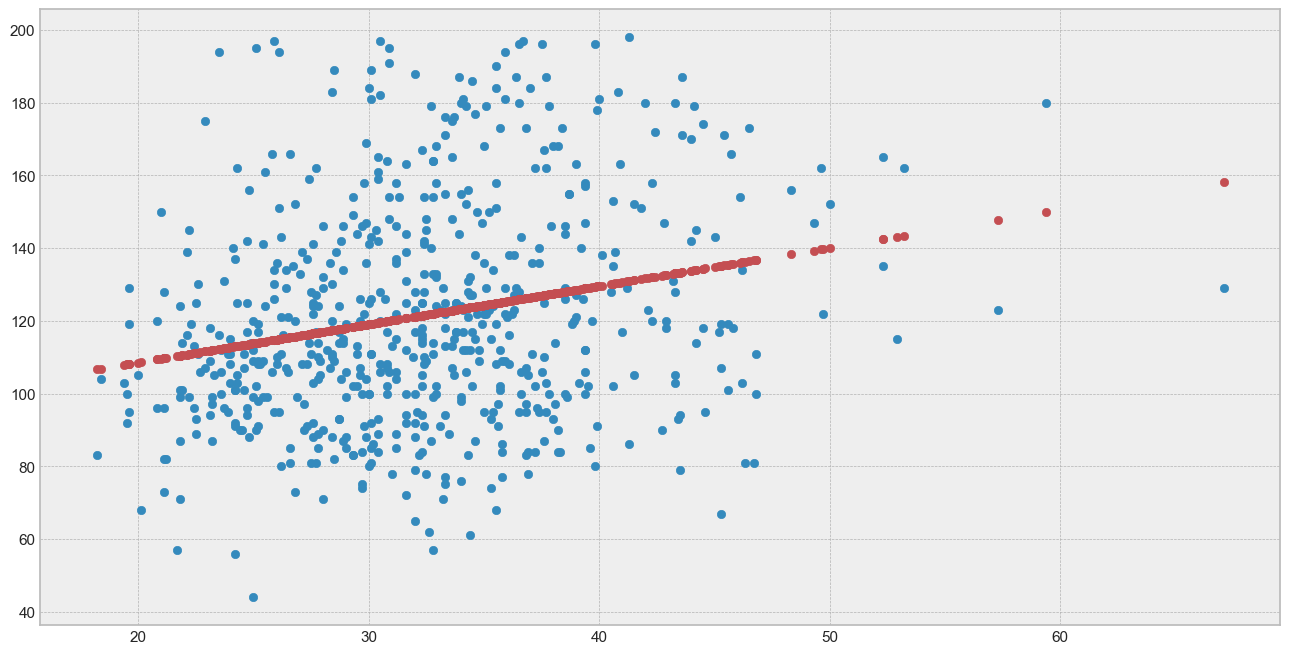

Mean Squared Error:  850.4097322734855


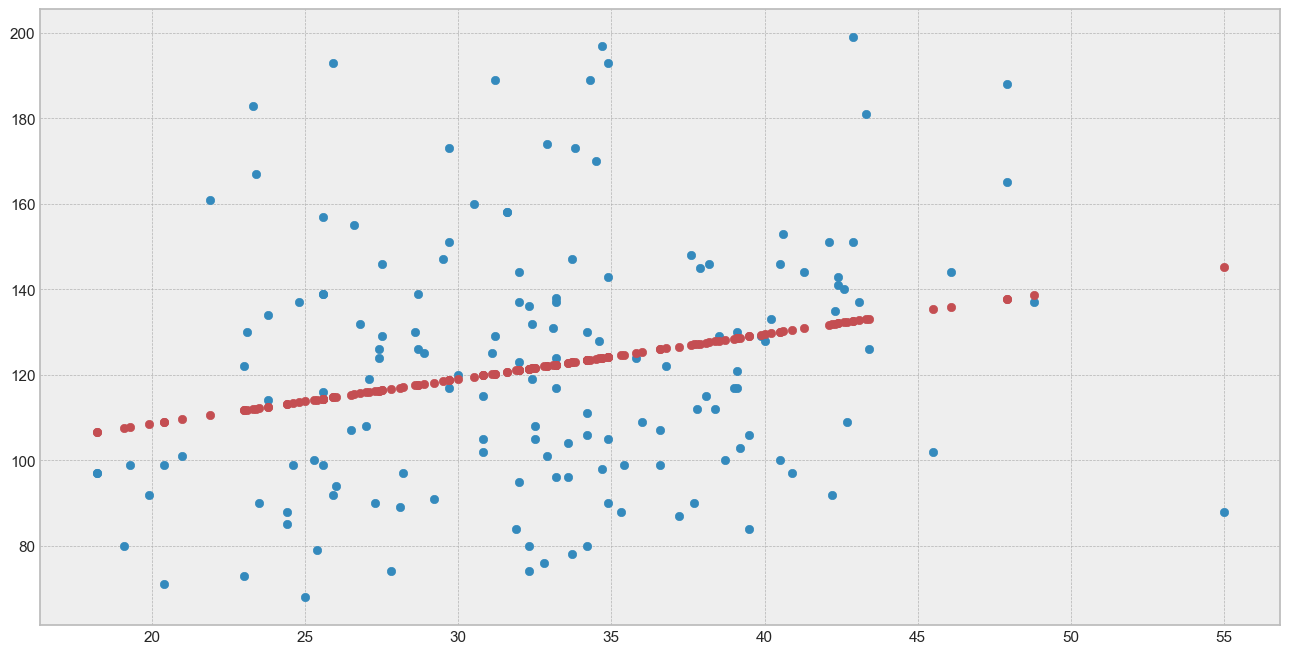

Score :  0.044844988057227586


In [17]:
data = pd.read_csv("diabetes.csv")

#Replace Glucose, BMI, Bloodpressure with median values
data[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] = data[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]].replace(0, np.NaN)
data["Glucose"] = data["Glucose"].replace(np.NaN, 117)
data["BMI"] = data["BMI"].replace(np.NaN, 32.3)
data["BloodPressure"] = data["BloodPressure"].replace(np.NaN, 72)


csvFrame = pd.DataFrame(data)

# jointFrame = csvFrame[["BMI","Glucose"]]
# calculateLinearRegression(jointFrame,"BMI","Glucose")

#older age implies an increase in glucose, which 
# jointFrame = csvFrame[["Age","Glucose"]]
# calculateLinearRegression(jointFrame,"Age","Glucose")

jointFrame = csvFrame[["BMI","Glucose"]]
calculateLinearRegression(jointFrame,"BMI","Glucose")

<div class="alert alert-warning">
    <strong>
    Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test<br>

BMI & Glucose: We can observe that the correlation for BMI and Glucose is a 0.24, which implies a slight positive correlation. The mean and median value of BMI is 31.99 and 32 respectively, which means that the sample is on people who are obese. This slight correlation suggest that even if you are obese, the higher the BMI, it is more likely that you will haveh higher levels of glucose.<br>

Age & Glucose: The correlatoion for Age & Glucose is 0.27, which implies a slight positive correlation. Even those majority of the people sampled ranges from age 20 to 40, we can still say that as a person ages, it is more likely that they will have higher level of glucose.<br>

Diabetes: Diabetes Pedigree Function, indicates the function which scores likelihood of diabetes based on family history. Cat plot for diabetes pedigree function and outcome(whether will have diabetes): Only a slight relation, meaning that if your family has a history of diabetes, it will only affect your chances of getting diabetes slightly. If we take the outliers of those who do not have diabetes, but their family history has, we can say that it offsets the slight correlation. We have about 20 outliers out of 500 data where their it shows that their family has a history of diabetes.<br>
    </strong>
</div>


<div class="alert alert-warning">
    <strong>Based on boxplots earlier, we determined which variable is most suitable to use inside our decision tree classifier.<br>
We chose the variables based on the spread on the boxplot to see which one has the most difference between the outcome.<br>
We chose Glucose, Age, BloodPressure and BMI.</strong>

</div>


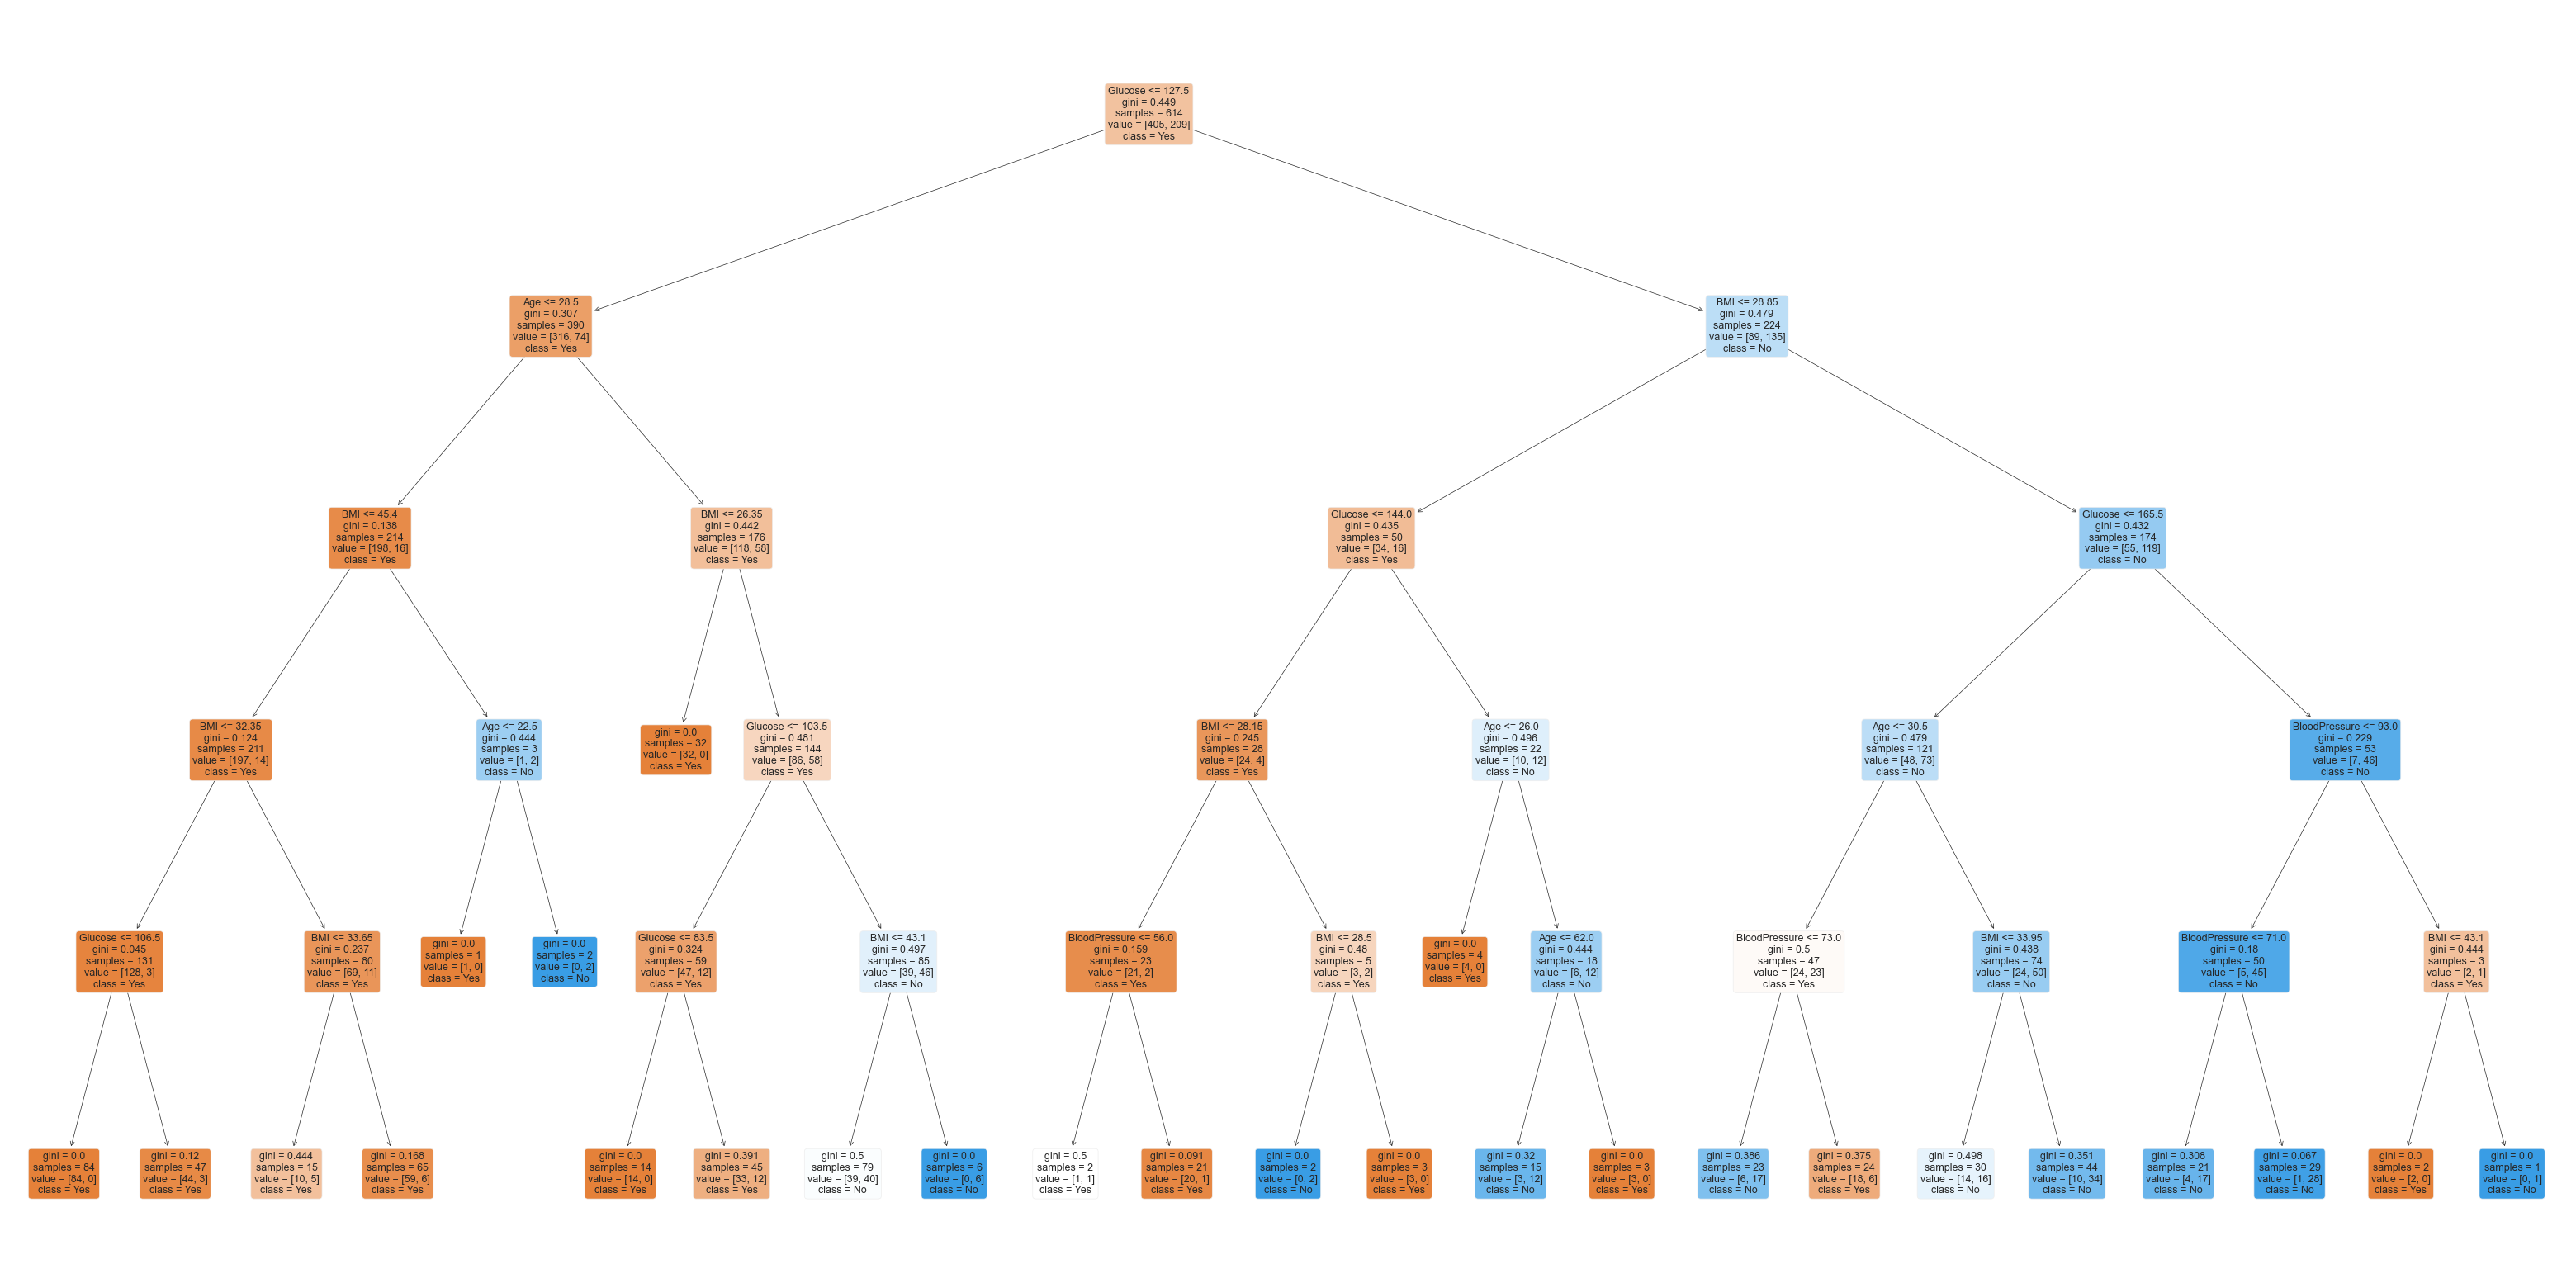

In [18]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

desdataDF = pd.DataFrame(data[["Glucose", "BMI", "BloodPressure", "Age"]])
outcomeDF = pd.DataFrame(data["Outcome"])
desdataTrain, desdataTest, outcomeTrain, outcomeTest = train_test_split(desdataDF, outcomeDF, test_size = 0.20)
dectree4 = DecisionTreeClassifier(max_depth = 5)
dectree4.fit(desdataTrain, outcomeTrain)

f = plt.figure(figsize=(40,20))
plot_tree(dectree4, filled=True, rounded=True, 
          feature_names=desdataTrain.columns, 
          class_names=["Yes","No"])
plt.show()

Train data: 	
Classification Accuracy 	: 0.8192182410423453
TN: 328
FN: 34
TP: 175
FP: 77
True Positive Rate:  0.8373205741626795
False Positive Rate:  0.19012345679012346


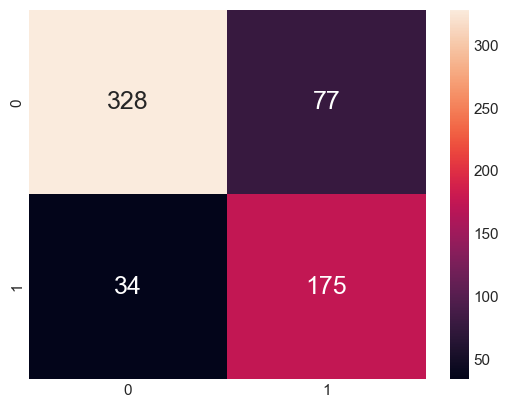

In [19]:
#Confusion Matrix
outcome_train_pred = dectree4.predict(desdataTrain)
sb.heatmap(confusion_matrix(outcomeTrain, outcome_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Train data: \t")
print("Classification Accuracy \t:", dectree4.score(desdataTrain, outcomeTrain))
TrainInfo = confusion_matrix(outcomeTrain, outcome_train_pred)
TN = TrainInfo[0][0]
FN = TrainInfo[1][0]
TP = TrainInfo[1][1]
FP = TrainInfo[0][1]

print("TN:",TN)
print("FN:",FN)
print("TP:",TP)
print("FP:",FP)
print("True Positive Rate: ", TP/(TP+FN)) #probability that an actual positive will test positive. 
print("False Positive Rate: ", FP/(TN+FP))

plt.show()

Test data: 	
Classification Accuracy 	: 0.7857142857142857
TN: 78
FN: 16
TP: 43
FP: 17
True Positive Rate:  0.7288135593220338
False Positive Rate:  0.17894736842105263


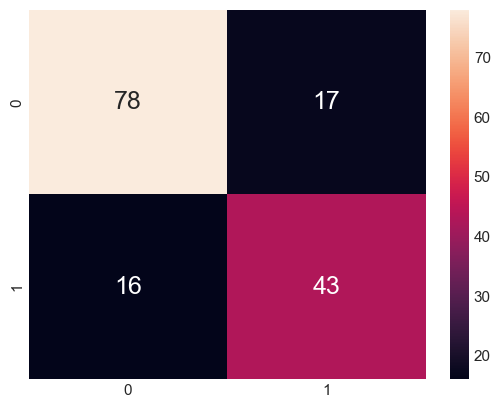

In [20]:
outcome_test_pred = dectree4.predict(desdataTest)
sb.heatmap(confusion_matrix(outcomeTest, outcome_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Print the Classification Accuracy
print("Test data: \t")
print("Classification Accuracy \t:", dectree4.score(desdataTest, outcomeTest))
TestInfo = confusion_matrix(outcomeTest, outcome_test_pred)
TN = TestInfo[0][0]
FN = TestInfo[1][0]
TP = TestInfo[1][1]
FP = TestInfo[0][1]

print("TN:",TN)
print("FN:",FN)
print("TP:",TP)
print("FP:",FP)
print("True Positive Rate: ", TP/(TP+FN)) #probability that an actual positive will test positive. 
print("False Positive Rate: ", FP/(TN+FP))
plt.show()

<div class="alert alert-warning">
    <strong>Based on the decision tree, we are able to conclude the glucose is the most important factor in diabetic outcome followed by age, BMI and blood pressure respectively.<br><br>The train data and test data has an accuracy of 0.8208 and 0.6818 respectively.
    </strong>

</div>


---
## Data Cleaning

<div class="alert alert-warning">
    <strong>In order to improve accuracy, we implemented an additional data cleaning step which is beyond our course using upsampling method.</strong>

</div>



In [21]:
#Upsampling

#set the minority class to a seperate dataframe
df_1 = data[data['Outcome'] == 1]
#set other classes to another dataframe
other_df = data[data['Outcome'] == 0] 

df_1_upsampled = resample(df_1,random_state=42,n_samples=1000,replace=True)
other_df_upsampled = resample(other_df,random_state=42,n_samples=1000,replace=True)

In [22]:
#Concat the upsampled dataframes together
c_upsampled_data = pd.concat([df_1_upsampled,other_df_upsampled])

#Shuffle rows
c_upsampled_data = c_upsampled_data.sample(frac=1)
c_upsampled_data = c_upsampled_data.reset_index()

#Drop Insulin and SkinThickness
c_upsampled_data = c_upsampled_data.drop(["Insulin", "SkinThickness", "index"], axis =1)

c_upsampled_data.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,122.0,90.0,49.7,0.325,31,1
1,2,146.0,76.0,38.2,0.329,29,0
2,0,124.0,70.0,27.4,0.254,36,1
3,0,129.0,110.0,67.1,0.319,26,1
4,3,173.0,82.0,38.4,2.137,25,1


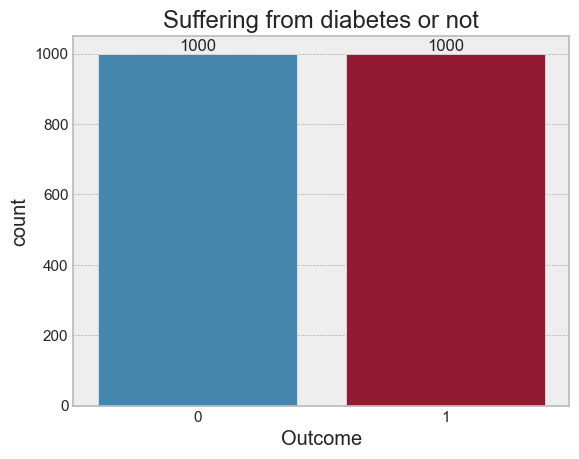

In [23]:
plt.style.use('bmh')
ax = sb.countplot(x= c_upsampled_data.Outcome , data= c_upsampled_data)
ax.bar_label(ax.containers[0])
ax.set_title('Suffering from diabetes or not')
plt.show()

In [24]:
X = pd.DataFrame(c_upsampled_data[["Glucose", "BloodPressure", "BMI", "Age"]])
y = pd.DataFrame(c_upsampled_data["Outcome"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=True)
X_train.head()

,Glucose,BloodPressure,BMI,Age
0,122.0,90.0,49.7,31
816,106.0,92.0,22.7,48
790,96.0,56.0,24.7,39
361,72.0,78.0,31.6,38
592,115.0,98.0,52.9,28


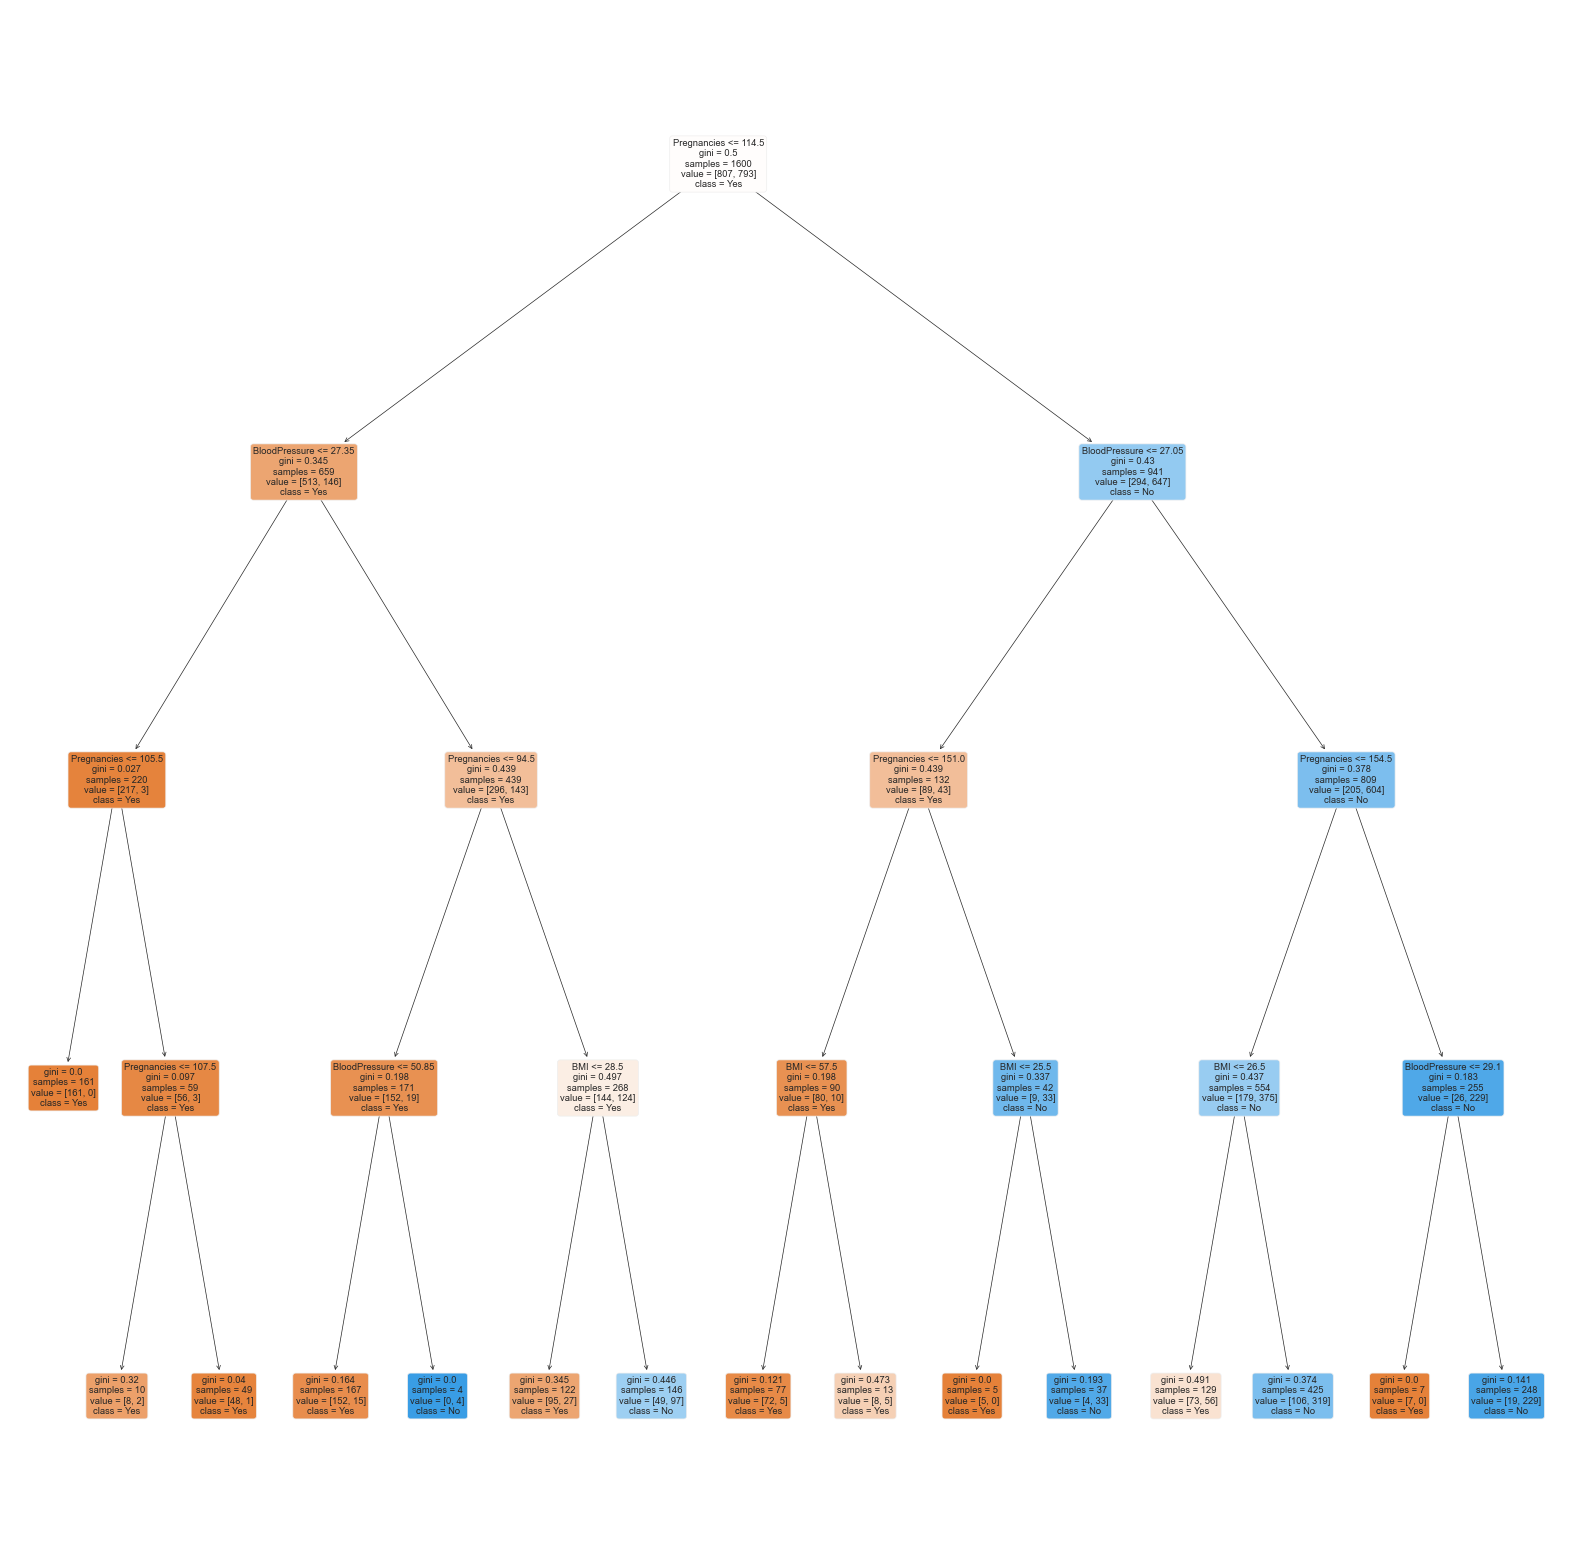

In [25]:
dectree5 = DecisionTreeClassifier(max_depth = 4)
dectree5.fit(X_train, y_train)

f = plt.figure(figsize=(20,20))
plot_tree(dectree5, filled=True, rounded=True, 
          feature_names=c_upsampled_data.columns, 
          class_names=["Yes","No"])
plt.show()

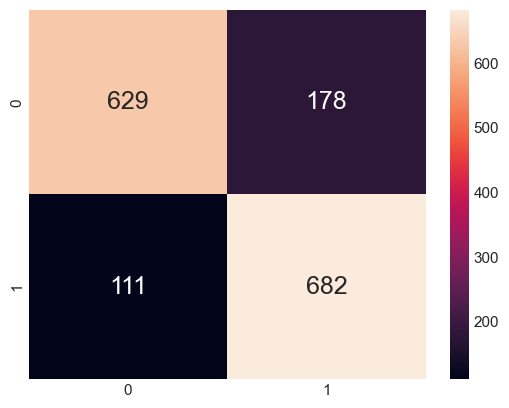

Train data: 	
Classification Accuracy 	: 0.819375
TN: 629
FN: 111
TP: 682
FP: 178
True Positive Rate:  0.8600252206809584
False Positive Rate:  0.22057001239157373


In [26]:
y_train_pred = dectree5.predict(X_train)
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

plt.show()

print("Train data: \t")
print("Classification Accuracy \t:", dectree5.score(X_train, y_train))
TrainInfo = confusion_matrix(y_train, y_train_pred)
TN = TrainInfo[0][0]
FN = TrainInfo[1][0]
TP = TrainInfo[1][1]
FP = TrainInfo[0][1]

print("TN:",TN)
print("FN:",FN)
print("TP:",TP)
print("FP:",FP)
print("True Positive Rate: ", TP/(TP+FN)) #probability that an actual positive will test positive. 
print("False Positive Rate: ", FP/(TN+FP)) 

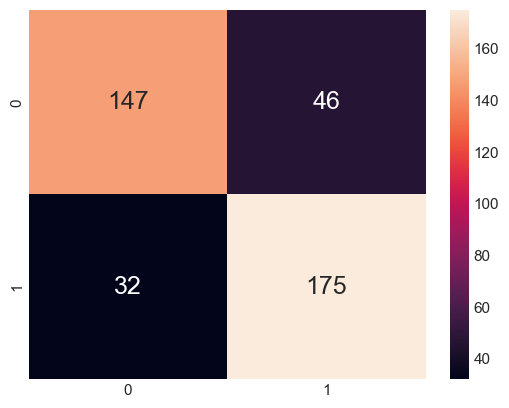

Test data: 	
Classification Accuracy 	: 0.805
TN: 147
FN: 32
TP: 175
FP: 46
True Positive Rate:  0.8454106280193237
False Positive Rate:  0.15458937198067632


In [27]:
y_test_pred = dectree5.predict(X_test)
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

plt.show()

# Print the Classification Accuracy
print("Test data: \t")
print("Classification Accuracy \t:", dectree5.score(X_test, y_test))
TestInfo = confusion_matrix(y_test, y_test_pred)
TN = TestInfo[0][0]
FN = TestInfo[1][0]
TP = TestInfo[1][1]
FP = TestInfo[0][1]

print("TN:",TN)
print("FN:",FN)
print("TP:",TP)
print("FP:",FP)
print("True Positive Rate: ", TP/(TP+FN)) #probability that an actual positive will test positive. 
print("False Positive Rate: ", FN/(FN+TP)) 

---
## Additional Prediction Methods

<div class="alert alert-warning">
    <strong>In order to improve accuracy, we seek for other predicting methods and made a comparison.</strong>

</div>

### Logistic Regression

<div class="alert alert-warning">
    <strong>Logistic regression is a simple yet very effective classification algorithm so it is commonly used for many binary classification task.<br>Since our data and prediction is in binary classification so we aren't sure whether it will give us the best result.</strong>

</div>

In [28]:
logistic_x = pd.DataFrame(c_upsampled_data[["Glucose", "BloodPressure", "BMI", "Age"]])
logistic_y = pd.DataFrame(c_upsampled_data["Outcome"])

log_x_train, log_x_test, log_y_train, log_y_test = train_test_split(logistic_x, logistic_y, test_size=0.2, random_state=1,shuffle=True)
log_x_train.head()

,Glucose,BloodPressure,BMI,Age
0,122.0,90.0,49.7,31
816,106.0,92.0,22.7,48
790,96.0,56.0,24.7,39
361,72.0,78.0,31.6,38
592,115.0,98.0,52.9,28


In [29]:
logisticRegression = LogisticRegression(max_iter=1000).fit(log_x_train, log_y_train)

logisticPrediction = logisticRegression.predict(log_x_test)

C:\Users\65936\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
mse = metrics.mean_squared_error(log_y_test, logisticPrediction)
print("Mean Squared Error: ", mse)

mae = metrics.mean_absolute_error(log_y_test, logisticPrediction)
print("Mean Squared Error: ", mae)

Mean Squared Error:  0.23
Mean Squared Error:  0.23


In [31]:
score = logisticRegression.score(log_x_test, log_y_test)
print("Test Accuracy Score", score)

Test Accuracy Score 0.77


<div class="alert alert-warning">
    <strong>However, based on the accuracy score of logistic regression, the binary decision tree was more accurate.</strong>

</div>

### Random Forest Tree

<div class="alert alert-warning">
    <strong>In a random forest classification, multiple decision trees are created using different random subsets of the data and features<br><br>
        Predictions are made by calculating the prediction for each decision tree, then taking the most popular result.
    </strong>

</div>

Best hyperparameters: {'max_depth': 17, 'n_estimators': 82}
Accuracy: 
0.9675


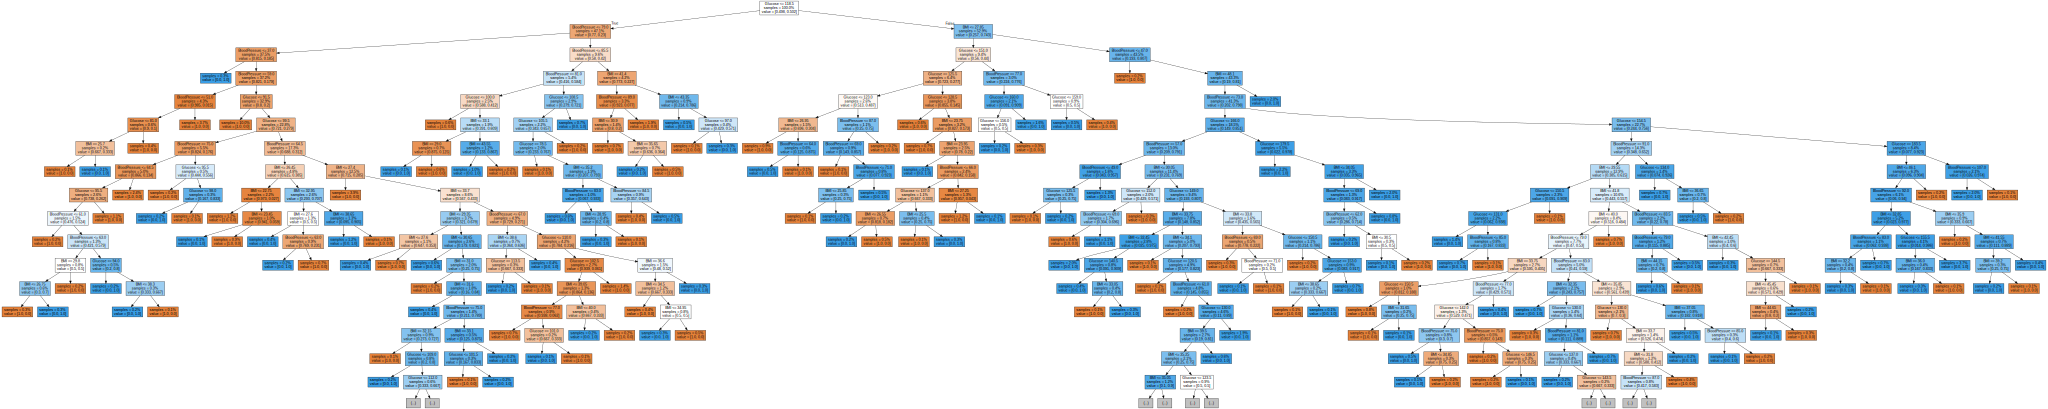

'Source.gv.png'

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

data = c_upsampled_data

treedataDF = pd.DataFrame(data[["Glucose", "BloodPressure", "BMI"]])
outcomeDF = pd.DataFrame(data["Outcome"])

#Code for testing accuracy if need.
# for i in range(0,20):
#     treedataTrain, treedataTest, outcomeTrain, outcomeTest = train_test_split(treedataDF, outcomeDF, test_size = 0.20)
#     rf = RandomForestClassifier()
#     rf.fit(treedataTrain, outcomeTrain.values.ravel())
#     y_pred = rf.predict(treedataTest)
#     accuracy = accuracy_score(outcomeTest, y_pred)
#     print("Accuracy:", accuracy)

treedataTrain, treedataTest, outcomeTrain, outcomeTest = train_test_split(treedataDF, outcomeDF, test_size = 0.20)
rf = RandomForestClassifier()
rf.fit(treedataTrain, outcomeTrain.values.ravel())

#Hyperparameter Tuning
param_dist = {'n_estimators': randint(1,500),
              'max_depth': randint(1,20)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(treedataTrain, outcomeTrain.values.ravel())

best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#Random Forest:
y_pred = rf.predict(treedataTest)
accuracy = accuracy_score(outcomeTest, y_pred)
print("Accuracy: ")
print(accuracy)

tree = rf.estimators_[50]

#f = plt.figure(figsize=(60,40))
#plot_tree(tree, filled=True, rounded=True, 
#          feature_names=c_upsampled_data.columns, 
#          class_names=["Yes","No"])
#plt.show()
#plt.figure(figsize=(20,8))

dot_data = export_graphviz(tree,
                                feature_names=treedataTrain.columns,  
                                filled=True,  
                                max_depth=16, 
                                impurity=False, 
                                proportion=True)
graph = graphviz.Source(dot_data, format='png')
display(graph)
graph.render()


<div class="alert alert-warning">
    <strong>Random forest tree would be the best classifier to determine whether a person is likely to have diabetes with an accuracy of 0.97 compared to decision tree and logistic regression.
    </strong>

</div>

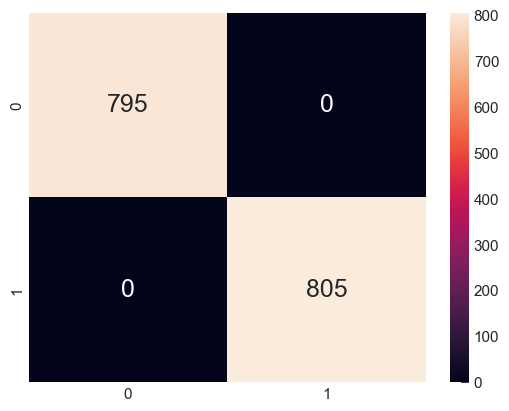

Train data: 	
Classification Accuracy 	: 1.0
TN: 795
FN: 0
TP: 805
FP: 0
True Positive Rate:  1.0
False Positive Rate:  0.0


In [33]:
y_train_pred = rf.predict(treedataTrain)
sb.heatmap(confusion_matrix(outcomeTrain, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

plt.show()

print("Train data: \t")
print("Classification Accuracy \t:", rf.score(treedataTrain, outcomeTrain))
TrainInfo = confusion_matrix(outcomeTrain, y_train_pred)
TN = TrainInfo[0][0]
FN = TrainInfo[1][0]
TP = TrainInfo[1][1]
FP = TrainInfo[0][1]

print("TN:",TN)
print("FN:",FN)
print("TP:",TP)
print("FP:",FP)
print("True Positive Rate: ", TP/(TP+FN)) #probability that an actual positive will test positive. 
print("False Positive Rate: ", FP/(TN+FP)) 

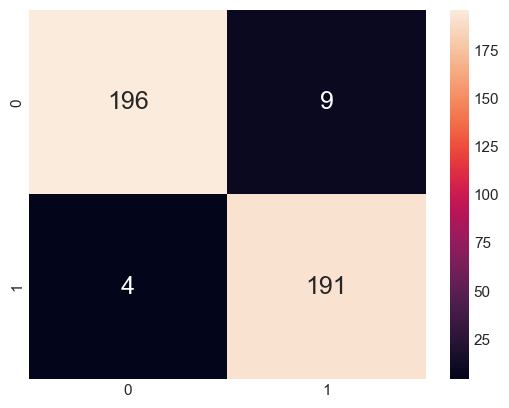

test data: 	
Classification Accuracy 	: 0.9675
TN: 196
FN: 4
TP: 191
FP: 9
True Positive Rate:  0.9794871794871794
False Positive Rate:  0.04390243902439024


In [34]:
y_test_pred = rf.predict(treedataTest)
sb.heatmap(confusion_matrix(outcomeTest, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

plt.show()

print("test data: \t")
print("Classification Accuracy \t:", rf.score(treedataTest, outcomeTest))
TrainInfo2 = confusion_matrix(outcomeTest, y_test_pred)
TN = TrainInfo2[0][0]
FN = TrainInfo2[1][0]
TP = TrainInfo2[1][1]
FP = TrainInfo2[0][1]

print("TN:",TN)
print("FN:",FN)
print("TP:",TP)
print("FP:",FP)
print("True Positive Rate: ", TP/(TP+FN)) #probability that an actual positive will test positive. 
print("False Positive Rate: ", FP/(TN+FP)) 

## K Nearest Neighbour Algorithm

In [35]:
from sklearn.preprocessing import StandardScaler
############################# Scaling ###################################
Knndata = c_upsampled_data

scaledX = StandardScaler()
X = pd.DataFrame(scaledX.fit_transform(Knndata.drop(["Outcome"], axis = 1),),columns=['Pregnancies', 'Glucose', 'BloodPressure',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])
Y = Knndata.Outcome

In [36]:
knn_x_train,knn_x_test,knn_y_train,knn_y_test = train_test_split(X,Y,test_size=1/3,random_state=42, stratify=y)

In [37]:
from sklearn.neighbors import KNeighborsClassifier


knn_test_scores = []
knn_train_scores = []

for i in range(1,15):
    knn_model = KNeighborsClassifier(i)
    knn_model.fit(knn_x_train,knn_y_train)
    
    knn_train_scores.append(knn_model.score(knn_x_train,knn_y_train))
    knn_test_scores.append(knn_model.score(knn_x_test,knn_y_test))

C:\Users\65936\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\65936\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\65936\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\65936\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [38]:
max_train_score = max(knn_train_scores)
train_scores_ind = [i for i, v in enumerate(knn_train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [39]:
max_test_score = max(knn_test_scores)
test_scores_ind = [i for i, v in enumerate(knn_test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 92.95352323838081 % and k = [1]


C:\Users\65936\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\65936\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


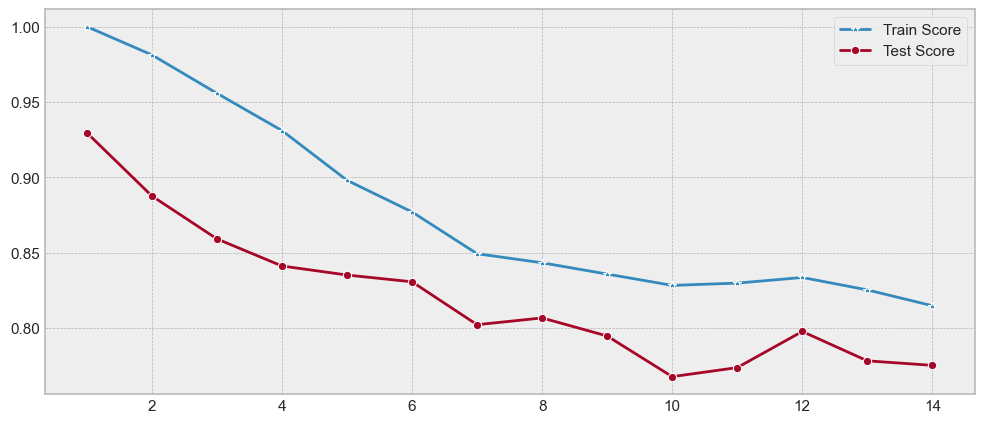

In [40]:
plt.figure(figsize=(12,5))
p = sb.lineplot(range(1,15),knn_train_scores,marker='*',label='Train Score')
p = sb.lineplot(range(1,15),knn_test_scores,marker='o',label='Test Score')

In [41]:
knn_model = KNeighborsClassifier(1)

knn_model.fit(knn_x_train,knn_y_train)
knn_model.score(knn_x_test,knn_y_test)

C:\Users\65936\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.9295352323838081

C:\Users\65936\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


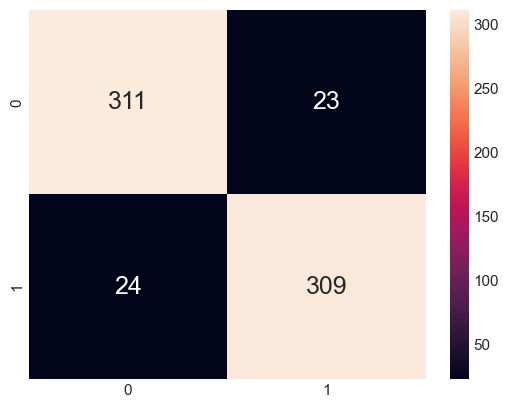

Test data: 	
Classification Accuracy 	: 0.9295352323838081
TN: 311
FN: 24
TP: 309
FP: 23
True Positive Rate:  0.9279279279279279
False Positive Rate:  0.07207207207207207


C:\Users\65936\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [42]:
knn_pred = knn_model.predict(knn_x_test)
sb.heatmap(confusion_matrix(knn_y_test, knn_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

plt.show()

# Print the Classification Accuracy
print("Test data: \t")
print("Classification Accuracy \t:", knn_model.score(knn_x_test, knn_y_test))
TestInfo = confusion_matrix(knn_y_test, knn_pred)
TN = TestInfo[0][0]
FN = TestInfo[1][0]
TP = TestInfo[1][1]
FP = TestInfo[0][1]

print("TN:",TN)
print("FN:",FN)
print("TP:",TP)
print("FP:",FP)
print("True Positive Rate: ", TP/(TP+FN)) #probability that an actual positive will test positive. 
print("False Positive Rate: ", FN/(FN+TP))